# Usage

In [1]:
# Setup colab
try:
    from mtphandler import PlateManager

except ImportError:
    print("Installing mtphandler...")
    !git clone --quiet https://github.com/FAIRChemistry/MTPHandler.git
    %cd MTPHandler
    !pip install . > /dev/null 2>&1
    %cd docs/examples

---

The following example demonstrates, how the `PlateManager` can be used to process the data from a 96-well plate reader. The workflow consists of the following steps:

1. Load the data of a plate from the devices' output file. 
2. Define the molecules and enzymes present in the assay.
3. Define the initial concentrations of each molecule and enzyme for the respective wells.
4. Blank the plate with respect to the molecules and enzymes present in each well.
5. Create a calibration model for the detected molecule.
6. Transform the data to concentration values in the EnzymeML format.

__Experimental Scenario__

![Reaction Scheme](../images/reaction_scheme.png)


Kinetic enzyme assays for the hydrolysis of _S_-adenosyl-_L_-homocysteine (`SAH`) or _S_-adenosyl-_L_-cysteine (`SIH`), catalyzed by four different _S_-adenosyl-_L_-homocysteine hydrolase (SAHH) enzymes, were conducted using a 96-well plate. Each reaction was carried out in triplicate for the respective enzymes as shown in the plate layout.  
For detection, Ellman's reagent (5,5'-dithiobis-2-nitrobenzoate) was used. It reacts with the homocysteine (`Hcy`) produced from the hydrolysis of SAH or SIH to form 2-nitro-5-thiobenzoate (`TNB`), which can be measured at an absorbance of 412 nm. The concentration of TNB was quantified using a calibration curve, which was also recorded on the same plate.

![Plate Layout](../images/plate%20SAHH.png)

The SAHH enzymes from _Mycoplasma capricolum_ (`McSAHH`), _Mycobacterium tuberculosis_ (`MtSAHH`), _Mycoplasma hyorhinis_ (`MhSAHH`), and _Thermotoga maritima_ (`TmSAHH`) were applied at a concentration of 5 µM, whereas the substrate concentration was 200 µM in all assays. The calibration curve for TNB was prepared in the range of 0 to 250 µM. Ellman's reagent was used at a concentration of 500 µM.

The goal of this workflow is to yield concentration time courses for the product TNB for each of the four enzymes and the two substrates, alongside the assigned reaction conditions in the standardized EnzymeML format. This enables further processing and fitting of the data with kinetic models to yield kinetic parameters for the respective enzymes.

## Read data

The `PlateManager` class provides a method to read the data from a range of different plate readers. The table below lists the supported file formats and the corresponding methods to read the data.

| Manufacturer       | Model                        | File Format | Method to read data |
|--------------------|------------------------------|-------------|---------------------|
| Agilent            | BioTek Epoch 2               | `xlsx`      | `read_biotek`       |
| Molecular Devices  | SpectraMax 190               | `txt`       | `read_spectra_max_190` |
| Tekan              | Magellan (processing software)| `xlsx`     | `read_tekan_magellan` |
| Tekan              | Spark                        | `xlsx`      | `read_tecan_spark`  |
| Thermo Scientific  | Multiskan Sky                | `xlsx`      | `read_multiskan_sky`|
| Thermo Scientific  | Multiskan Spectrum 1500      | `txt`       | `read_multiskan_spectrum_1500`|

Depending on the information that is available in the output file, some additional information might be provided to the read method. The following arguments are common to all read methods:

__Common arguments:__

- `path`: Path to the plate reader output file.
- `ph`: The pH value if it is the same for all wells.
- `name`: An optional descriptive name for the assay.

__Additional arguments:__

- `time`: A list of time points corresponding to the time at which each measurement was taken.
- `time_unit`: The unit of the time points.
- `temperature`: The temperature at which the assay was conducted.
- `temperature_unit`: The unit of the temperature. Default is `°C`.
- `wavelegth`: The wavelength at which the measurements were taken.

For most of the read methods the additional arguments are not required, as the information is extracted from the file.

The following example demonstrates how to read the data from a SpectraMax 190 plate reader output file:

In [2]:
from mtphandler import PlateManager

# Define the path to the data file
path = "data/spectra_max_190.txt"

# Read the data file and create a PlateManager object called `plate`
plate = PlateManager.read_spectra_max_190(
    path=path,
    ph=7.4,
    name="SAHH kinetic assay",
)

# Visualize the data
plate.visualize(zoom=False, wavelengths=[], darkmode=False)


## Define Molecules and Proteins

After the plate is loaded, the species which were used in the assay need to be defined. this is done by using the `define_molecule` and `define_protein` respectively. 

### Define Molecules

__Required arguments:__

- `id`: An arbitrary identifier for the molecule. Please note that the identifier may not contain spaces or special characters except for underscores.
- `pubchem_cid`: The PubChem Compound ID of the molecule<span class="annotate">(1)</span><ol><li>If available, the PubChem CID should be provided. This ensures, that in a molecules is always referenced by the same identifier. This is important for the interoperability of the data.</li></ol>. You can find the PubChem CID by searching for the molecule on the [PubChem website](https://pubchem.ncbi.nlm.nih.gov/). If the PubChem CID is not available, you can set the `pubchem_cid` to `-1` to indicate that the molecule is not present in the PubChem database.

__Optional arguments:__

- `name`: The name of the molecule. If the pubchem_cid is provided, the name is retrieved from the PubChem database. If the PubChem ID is not available, the name must be provided manually.
- `constant`: Whether or not the concentration of the molecule is constant. Default is `False`.

In [3]:
# Define molecules
BUFFER = plate.define_molecule(
    id="BUFFER", pubchem_cid=-1, name="Buffer", constant=True
)

TNB = plate.define_molecule(id="TNB", pubchem_cid=6254, constant=False)

SAH = plate.define_molecule(id="SAH", pubchem_cid=439155, constant=False)

SIH = plate.define_molecule(id="SIH", pubchem_cid=135618563, constant=False)

Hyc = plate.define_molecule(id="Hyc", pubchem_cid=91552, constant=False)

DTNB = plate.define_molecule(id="DTNB", pubchem_cid=6254, constant=False)

### Define Proteins

Proteins are defined in a similar way as molecules. To define a protein, the `define_protein` method is used.

__Required arguments:__

- `id`: An arbitrary identifier for the protein. Please note that the identifier may not contain spaces or special characters except for underscores.
- `name`: Arbitrary name of the protein.

__Optional arguments:__

- `uniprot_id`: The UniProt ID of the protein. You can find the UniProt ID by searching for the protein on the [UniProt website](https://www.uniprot.org/).
- `sequence`: The amino acid sequence of the protein.
- `constant`: Whether or not the concentration of the protein is constant throughout the assay. Default is `True`.

In [4]:
McSAHH = plate.define_protein(
    id="McSAHH", name="Mycoplasma capricolum SAHH", constant=True
)

MtSAHH = plate.define_protein(
    id="MtSAHH",
    name="Mycobacterium tuberculosis SAHH",
    constant=True,
    uniprot_id="P9WGV3",
)

MhSAHH = plate.define_protein(
    id="MhSAHH", name="Mycoplasma hyorhinis SAHH", constant=True
)

TmSAHH = plate.define_protein(
    id="TmSAHH", name="Thermotoga maritima SAHH", constant=True, uniprot_id="O51933"
)

## Assign initial concentrations

After defining the molecules and proteins, the initial concentrations of each molecule and protein in the respective wells need to be assigned. The most convenient way to do this is by using an Excel spreadsheet - especially when dealing with many different species and initial conditions like in this example. To read the in the Excel file, the `assign_init_conditions_from_spreadsheet` method is used. Therefore, only the `path` and the `concentration_unit` arguments are required. This method goes through the sheets of an Excel spreadsheet. Each sheet represents the plate map of a molecule or protein. The sheet name must match the id of the molecule or protein defined for the plate. The initial concentration from the plate map in the Excel spreadsheet is assigned to the respective well. The following requirements must be met for the structure of the Excel spreadsheet:

__Requirements structure of the Excel spreadsheet:__

- The first row must contain the column numbers from 1 to 12.
- The first column must contain the row letters from A to H.
- Leaving cells empty is means that the respective species in not present in the well over the course of the experiment.
- Products of the reaction need to be set to a concentration of 0.

After the Excel spreadsheet is created, the initial concentrations can be assigned to the respective wells using the `assign_init_conditions_from_spreadsheet` method.

In [5]:
from mtphandler.units import uM

# Blank Plate from plate map
plate.assign_init_conditions_from_spreadsheet(
    conc_unit=uM,
    path="data/plate_map_SAHH_kinetics.xlsx",
)

📍 Assigned 228 initial concentration coditions for ['TmSAHH', 'SIH', 'McSAHH', 'BUFFER', 'MhSAHH', 'SAH', 'Hyc', 
'MtSAHH', 'DTNB', 'TNB'] from data/plate_map_SAHH_kinetics.xlsx to the plate.


Alternatively, the assignment of the initial concentrations can be done manually using the `assign_init_conditions` method. With this method the init concentrations can be assigned to entire rows, or columns, to all wells, or to individual wells. Please refer to the [API documentation](api_reference/plate_manager.md) for more information.


## Blanking of the plate

### Automatic blanking

Since the initial concentrations of the molecules and proteins are defined, the plate can be blanked with respect to the molecules and proteins and their respective concentration present in each well. The `blank_species` method is used to blank the plate. The method takes a `species`, which is one of the previously defined molecules or proteins, and the `wavelength` for which the blanking should be performed. The `wavelength` is optional as long as only one wavelength was measured. If multiple wavelengths were measured, the `wavelength` argument is required. If the `silent` argument is not set to `True`, the method will print the mean absorption of the species at the respective concentration and the wells used for the calculation.

Make sure to blank the buffer first, before blanking the other species. If done the other way around, the wells which can be used to calculate the contribution of a species to the measured signal are not correctly identified.

In [6]:
# First the buffer
plate.blank_species(BUFFER)

# Then the all other species
plate.blank_species(SAH)
plate.blank_species(SIH)
plate.blank_species(McSAHH)
plate.blank_species(MtSAHH)
plate.blank_species(MhSAHH)
plate.blank_species(TmSAHH)

Mean absorption of Buffer (BUFFER) at 50.0 umol / l: 0.1072 ± 6%  calculated based on wells ['D11', 'E11', 'F11', 
'G11'].

Blanked 60 wells containing Buffer.

Mean absorption of S-adenosyl-L-homocysteine (SAH) at 200.0 umol / l: -0.0051 ± 76%  calculated based on wells 
['B11'].

Blanked 13 wells containing S-adenosyl-L-homocysteine.

Mean absorption of S-Inosylhomocysteine (SIH) at 200.0 umol / l: 0.0104 ± 63%  calculated based on wells ['C11'].

Blanked 13 wells containing S-Inosylhomocysteine.

Mean absorption of Mycoplasma capricolum SAHH (McSAHH) at 5.0 umol / l: 0.2990 ± 20%  calculated based on wells 
['B5', 'B6', 'B7'].

Blanked 9 wells containing Mycoplasma capricolum SAHH.

Mean absorption of Mycobacterium tuberculosis SAHH (MtSAHH) at 5.0 umol / l: 0.3711 ± 7%  calculated based on wells
['E5', 'E6', 'E7'].

Blanked 9 wells containing Mycobacterium tuberculosis SAHH.

Mean absorption of Mycoplasma hyorhinis SAHH (MhSAHH) at 5.0 umol / l: 0.1771 ± 10%  calculated based on wells 
['B8', 'B9', 'B10'].

Blanked 9 wells containing Mycoplasma hyorhinis SAHH.

Mean absorption of Thermotoga maritima SAHH (TmSAHH) at 5.0 umol / l: 0.0199 ± 29%  calculated based on wells 
['E8', 'E9', 'E10'].

Blanked 9 wells containing Thermotoga maritima SAHH.

### Manually changing the absorption contribution of a species

In some cases, it is already knows that a certain species does not contribute to the measured signal. In this case, the absorption contribution of the species can be set to zero using the `set_absorption_contribution` method. The method takes the `species` for which the absorption contribution should be set to zero and the `wavelength` at which the measurements were taken. The `wavelength` is optional as long as only one wavelength was measured. If multiple wavelengths were measured, the `wavelength` argument is required.

In the SAHH kinetic assay, the contribution of the Ellman's reagent `DTNB` is known not to absorb at the measured wavelength. And since no control wells are available to calculate the contribution of `DTNB`, the absorption contribution of `DTNB` is manually set to zero.

In [7]:
plate.set_absorption_contribution(species=DTNB, contributes_to_signal=False)

Set signal contribution of 5,5'-Dithiobis(2-nitrobenzoic acid) (DTNB) at 412.0 nm to False.

## Create calibration model

__Initialize a calibrator:__

Next a calibration model for later quantification of the detected molecule `TNB` is created. The `get_calibrator` method is used to create a `Calibrator` object, which facilitates the process of creating and choosing a calibration model for a molecule. The method takes the `species` for which the calibration model should be created and the `wavelength` at which the measurements were taken. The `wavelength` is optional as long as only one wavelength was measured. If multiple wavelengths were measured, the `wavelength` argument is required. Furthermore, the `cutoff` can be specified to exclude wells with a measured signal above the defined cutoff from the calibration model. This allows to exclude wells with false signals at the upper detection limit of the plate reader.

The method returns a `Calibrator`. By default the calibrator comes with a linear, quadratic, and cubic calibration model, which do not consider a parameter for the intercept. Thus catering the assumption that the signal at zero concentration is zero, which is the case for correctly blanked data. Optionally, custom calibration models can be added to the calibrator. For further information on how to add custom calibration models, please refer to the [documentation of the calibrator](https://fairchemistry.github.io/CaliPytion/usage/).

__Fit and visualize the calibration models:__

After initializing the calibrator object, the predefined models can be fitted by calling the `fit_models` and `visualize` method. Then, an overview with statistical parameters as well as the fitted calibration models are displayed.

In [8]:
# Initialize the calibrator for TNB
TNB_calibrator = plate.get_calibrator(TNB)

# Fit and visualize the calibration models
TNB_calibrator.fit_models()
TNB_calibrator.visualize()

🔎 Found 18 wells containing 5,5'-Dithiobis(2-nitrobenzoic acid) (TNB).
✅ Models have been successfully fitted.


                                                  Model Overview                                                   
┏━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model Name ┃ AIC  ┃ R squared ┃ RMSD   ┃ Equation                          ┃ Relative Parameter Standard Errors ┃
┡━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cubic      │ -183 │ 0.9995    │ 0.0136 │ a * TNB + b * TNB**2 + c * TNB**3 │ a: 5.7%, b: 14.3%, c: 19.3%,       │
│ quadratic  │ -175 │ 0.9992    │ 0.0163 │ a * TNB + b * TNB**2 + c          │ a: 2.6%, b: 13.8%, c: 27.7%,       │
│ linear     │ -133 │ 0.9938    │ 0.0462 │ a * TNB                           │ a: 1.3%,                           │
└────────────┴──────┴───────────┴────────┴───────────────────────────────────┴────────────────────────────────────┘

__Choose best calibration model:__

After considering the statistical parameters of the fitted calibration models, the best calibration model can be chosen which will finally be used to quantify the detected molecule. Therefore, the desired model is first registered with the calibrator, before it is added to the molecule for which the calibration was conducted. 

The following example shows how the `cubic` calibration model is chosen as the best model for `TNB` and registered with the molecule.

In [9]:
# Add the cubic model to the Standard of the calibrator
TNB_calibrator.add_model_to_standard(model="cubic")

# Register the calibrator standard to the `TNB` molecule
TNB.standard = TNB_calibrator.standard

## Convert to EnzymeML

Finally, the enriched and processed data can be transformed into an `EnzymeMLDocument` object. this is done by calling the `to_enzymeml` method.

__Required arguments:__

- `detected_molecule`: The molecule that was detected in the assay.

__Optional arguments:__

- `name`: An optional name for the EnzymeML document. If not provided, the name of the assay is used.
- `wells_with_protein_only`: If set to `True`, only wells containing one or more proteins and the `detected_molecule` are included in the EnzymeML document. Default is `False`.
- `well_ids`: Optionally, only a subset of wells can be included in the EnzymeML document by providing a list of well IDs. This enables for instance to create four separate EnzymeML documents for each of the assayed enzymes in this scenario.
- to_concentration: If set to `True`, the measured signals are converted to concentrations using definde calibration models. Default is `False`. Otherwise the measured signals are included in the EnzymeML document.
- `extrapolate`: If set to `True`, the calibration model is used to extrapolate the concentration of the detected molecule in wells where the signal was below or above the detection limit. Default is `False`. 
- `wavelegth`: The wavelength at which the measurements were taken. If only one wavelength was measured, the `wavelength` argument is optional. If multiple wavelengths were measured, the `wavelength` argument is required.

In [10]:
enzml_TmSAHH_SAH = plate.to_enzymeml(
    name="TmSAHH with SAH substrate kinetic assay",
    detected_molecule=TNB,
    well_ids=["F8", "F9", "F10", "E8", "E9", "E10"],
    to_concentration=True,
    extrapolate=True,
    catalyzed_only=True,
)

added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
added temp unit s
✅ Added measurements from 6 wells with concentration values to EnzymeMLDocument


To quickly inspect the generated `EnzymeMLDocument`, the data can be visualized with the following code snippet.

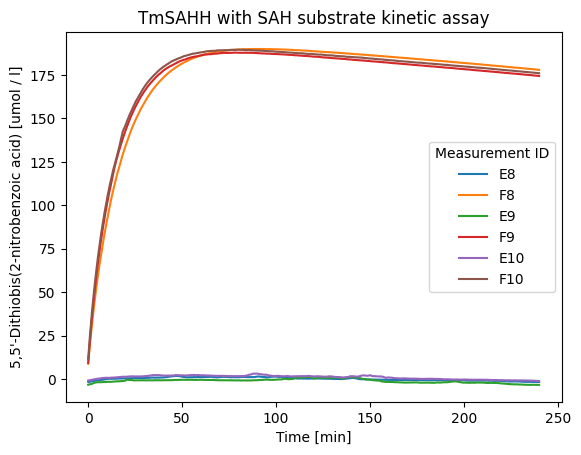

In [11]:
from matplotlib import pyplot as plt

# Iterate over all measurements in the EnzymeML document
# and plot the data if there is any
for measurement in enzml_TmSAHH_SAH.measurements:
    for species in measurement.species_data:
        if species.data:
            measured_species = species
            plt.plot(species.time, species.data, label=measurement.id)

# get the name of the species that has data
measured_species = enzml_TmSAHH_SAH.filter_small_molecules(
    id=measured_species.species_id
)[0]

# add legend and labels
plt.xlabel("Time [min]")
plt.ylabel(f"{measured_species.name} [{species.data_unit.name}]")
plt.title(f"{enzml_TmSAHH_SAH.name}")
plt.legend(title="Measurement ID")
plt.show()

### Serialize the EnzymeML Document

With the following code snippet the generated `EnzymeMLDocument` can be saved as an `.json` file, or as an SBML `.xml` file.

In [12]:
from pyenzyme import EnzymeMLDocument
import json

# Save the EnzymeML document to a file
with open("data/enzymeml_TmSAHH_SAH.json", "w") as file:
    file.write(enzml_TmSAHH_SAH.model_dump_json(indent=4))

# Read the EnzymeML document from a file
with open("data/enzymeml_TmSAHH_SAH.json", "r") as file:
    loaded_enzymeml = EnzymeMLDocument(**json.load(file))